In [28]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
 
%matplotlib inline
%load_ext autoreload
%autoreload 2
 
from os.path import join as pjoin
import glob
import numpy as np
from numpy import hstack as stack
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['image.cmap'] = 'inferno'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [461]:
# Retail sales of beer, wine and liquor in the U.S.
# Monthly data from January 1992 till November 2017
BeerWine = pd.read_csv('data/BeerWineUS.csv', header=0, index_col=0,
                       squeeze=True)

# Real (inﬂation corrected) interest rate for bank deposits with
# investment durations between one and two years
interestrate = pd.read_csv('data/interestrate.csv', sep=';',
                           index_col=0, header=None).iloc[:,0]
interestrate = interestrate.map(lambda s: float(s.replace(',', '.')))

# Crude oil price per barrel
CrudeOil = pd.read_csv('data/CrudeOil.csv', header=0, index_col=0, squeeze=True)

# 3

Simple forecasting and forecasting with exponential smoothing with `BeerWineUS.csv`. Begin the forecasting starting with the observation 201. Thus the out-of-sample performance of the below methods will be assessed using the forecasts for the periods 201 to 311.

In [485]:
def show_series(train, test):
    minv = stack((train.values, test.values)).min()
    maxv = stack((train.values, test.values)).max()
    plt.plot(train.index, train.values, label='train')
    plt.vlines(train.index[-1], min(0, minv), maxv, 'gray', '--')
    plt.plot(test.index, test.values, label='test')
    plt.legend()
    plt.xticks(stack((train.index, test.index))[::50])
    plt.yticks(stack(np.linspace(min(0, minv), maxv, 10)))
#     plt.show()

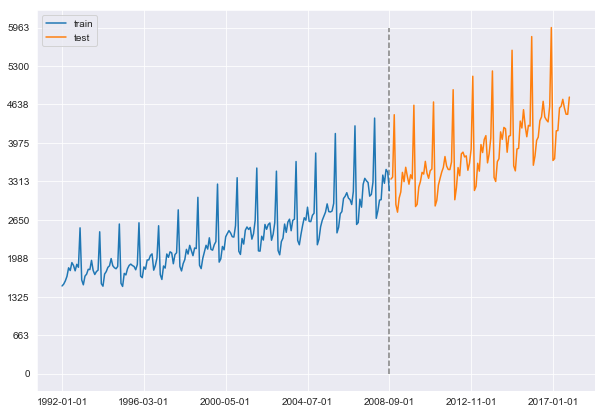

In [486]:
mpl.rcParams['figure.figsize'] = (10,7)
N = len(BeerWine)
n_train = 201
train = BeerWine.iloc[:n_train]
test = BeerWine.iloc[n_train:]
show_series(train, test)
n_test = len(test)

In [321]:
def MA(train, test, k=10):
    n_test = len(test)
    forecast_values = []
    for i in range(n_test):
        train_k = stack((train.values[n_train-k+i:], forecast_values[max(i-k,0):i]))
        forecast_values.append(train_k.mean())
    return pd.Series(forecast_values, index=test.index)

def EWMA(train, test, alpha=0.5):
    n_train, n_test = len(train), len(test)
    forecast_values = [train.values[0]]
    for i in range(1,n_train):
        forecast_values.append(alpha * train.values[i-1] + (1 - alpha) * forecast_values[i-1])
    forecast_values.extend([forecast_values[-1]]*n_test)
    return pd.Series(forecast_values, index=stack((train.index, test.index)))

def Holt(train, test, alpha=0.3, beta=0.4):
    level, trend = [train.values[0]], [0]
    for i in range(1, n_train):
        level.append(alpha * train.values[i] + (1- alpha) * (level[i-1] + trend[i-1]))
        trend.append(beta * (level[i] - level[i-1]) + (1- beta) * trend[i-1])
#     forecast_values = level[-1] + trend[-1] * np.arange(n_test)
#     return pd.Series(forecast_values, index=test.index)
    forecast_values = stack((level, level[-1] + trend[-1] * np.arange(n_test)))
    return pd.Series(forecast_values, index=stack((train.index, test.index)))

def HoltWinters(train, test, alpha=0.3, beta=0.4, gamma=0.1, s=1):
    n_test = len(test)
    level, trend, season = [train.values[0]], [0], [0]
    for i in range(1, n_train):
        level.append(alpha * train.values[i] + (1- alpha) * (level[i-1] + trend[i-1]))
        trend.append(beta * (level[i] - level[i-1]) + (1- beta) * trend[i-1])
        season.append(gamma * (train.values[i] - level[i]) + (1 - gamma) * season[max(i-s, 0)])
#     forecast_values = level[-1] + trend[-1] * np.arange(n_test)
#     return pd.Series(forecast_values, index=test.index)
    S = level[-1] + trend[-1] * np.arange(n_test) + \
        stack((np.repeat([season[-s:]], n_test // s, 0).flatten(),
              season[:n_test % s]))
    forecast_values = stack((level + stack((np.zeros(s), season[:-s])), S))
    return pd.Series(forecast_values, index=stack((train.index, test.index)))

(a) Compute forecasts using simple EWMA, Holt and Holt-Winters forecasts with the smoothing parameters calibrated from the ﬁrst 200 observations.

In [392]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

ewma = ExponentialSmoothing(train, trend=None, damped=False, seasonal=None)
forecast_values = ewma.predict(ewma.fit().params,
                               start='1992-01-01', end='2017-11-01')
ewma_result = pd.Series(forecast_values, index=BeerWine.index)
ewma_forecast = ewma_result.iloc[n_train:]

holt = ExponentialSmoothing(train, trend='add', damped=False, seasonal=None)
forecast_values = holt.predict(holt.fit().params,
                               start='1992-01-01', end='2017-11-01')
holt_result = pd.Series(forecast_values, index=BeerWine.index)
holt_forecast = holt_result.iloc[n_train:]

holtWinters = ExponentialSmoothing(train, trend='add', damped=False,
                                   seasonal='mul', seasonal_periods=12)
forecast_values = holtWinters.predict(holtWinters.fit().params,
                                      start='1992-01-01', end='2017-11-01')
holtWinters_result = pd.Series(forecast_values, index=BeerWine.index)
holtWinters_forecast = holtWinters_result.iloc[n_train:]

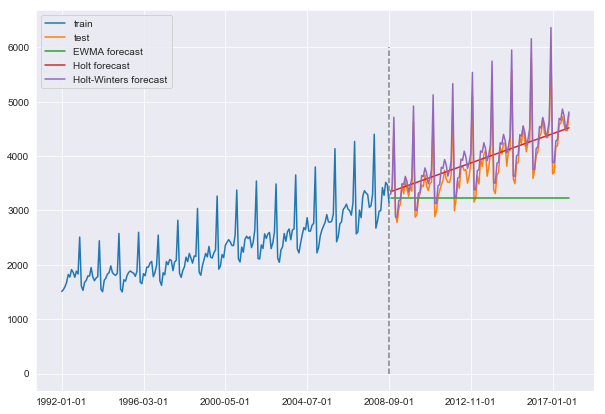

In [393]:
show_series(train, test)

# EWMA
plt.plot(ewma_forecast, label='EWMA forecast')

# Holt
plt.plot(holt_forecast, label='Holt forecast')

# Holt-Winters
plt.plot(holtWinters_forecast, label='Holt-Winters forecast')

plt.legend()
plt.show()

In [382]:
# plt.plot(MA(train, test, k=50))
# plt.plot(EWMA(train, test, alpha=ewma.params['smoothing_level']))
# plt.plot(Holt(train, test,
#               alpha=holt.params['smoothing_level'],
#               beta=holt.params['smoothing_slope']))
# plt.plot(HoltWinters(train, test,
#                      alpha=holtWinters.params['smoothing_level'],
#                      beta=holtWinters.params['smoothing_slope'],
#                      gamma=holtWinters.params['smoothing_seasonal'], s=12))

(b) Compute the corresponding MSE losses. Check the ACF of the forecast errors.

In [397]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf

print(mean_squared_error(test, ewma_forecast))
print(mean_squared_error(test, holt_forecast))
print(mean_squared_error(test, holtWinters_forecast))

791343.758575698
234909.30242834607
38023.62693316736


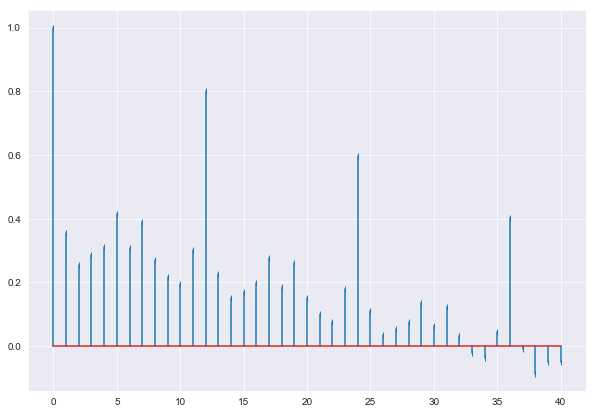

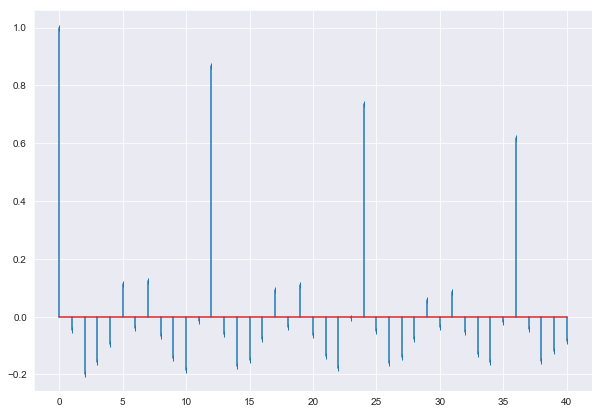

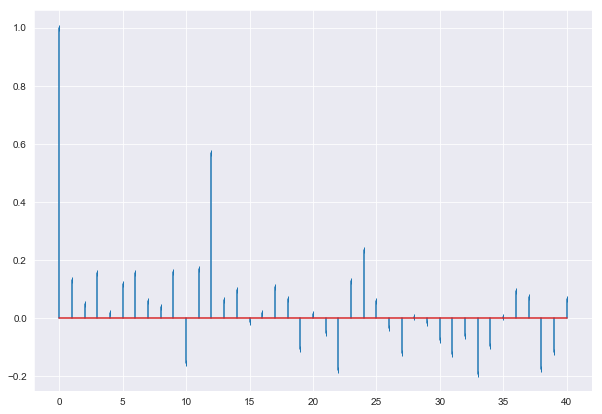

In [488]:
def ACF(y, y_pred=None):
    if y_pred is not None:
        y = y - y_pred
    plt.stem(acf(y), markerfmt='|')
#     plt.stem(acf(np.abs(y - y_pred)), markerfmt='|')
    plt.show()
    
# plt.stem(acf(test - ewma_forecast), markerfmt='|')
ACF(test, ewma_forecast)
ACF(test, holt_forecast)
ACF(test, holtWinters_forecast)

(c) Compare the performance of the models using the three tests discussed in the lectures.

# 4

ARMA modelling with `interestrate.csv`. Keep the last year for forecasting.

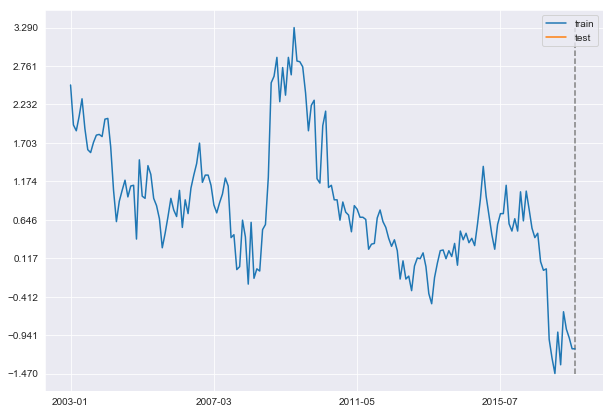

In [489]:
mpl.rcParams['figure.figsize'] = (10,7)
N = len(interestrate)
n_train = N-1
train = interestrate.iloc[:n_train]
test = interestrate.iloc[n_train:]
n_test = len(test)
show_series(train, test)

(a) Check the ACF and decide about the strength of the memory in the time series using Box-Ljung/Pierce tests.

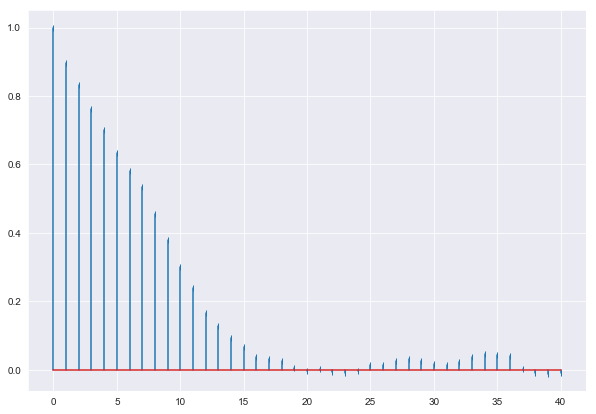

In [490]:
ACF(train)

In [493]:
import sys
!{sys.executable} -m pip install pyflux --user

  Using cached https://files.pythonhosted.org/packages/37/e2/ac8ea14d34556e83a9fe9e23ba7b02ca14951849b9637c238ca83d04ac3c/pyflux-0.4.15.tar.gz
  Using cached https://files.pythonhosted.org/packages/3f/b2/a492a473c3bcdfe8889986beb331e7198a718282de8c0ec8c9fec947878c/numdifftools-0.9.20-py2.py3-none-any.whl
  Running setup.py bdist_wheel for pyflux ... error
  Complete output from command /Users/Yaroslava/anaconda/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/f9/t_b5y0tx5l7f5c1qbxj2pklh0000gn/T/pip-install-pm8xuwzw/pyflux/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /private/var/folders/f9/t_b5y0tx5l7f5c1qbxj2pklh0000gn/T/pip-wheel-9j3tnlhu --python-tag cp37:
  running bdist_wheel
  running build
  running config_cc
  unifing config_cc, config, build_clib, build_ext, build commands --compiler options
  running config_fc
  unifing config_fc, config, bu

Failed to build pyflux
  Running setup.py install for pyflux ... error
    Complete output from command /Users/Yaroslava/anaconda/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/f9/t_b5y0tx5l7f5c1qbxj2pklh0000gn/T/pip-install-pm8xuwzw/pyflux/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /private/var/folders/f9/t_b5y0tx5l7f5c1qbxj2pklh0000gn/T/pip-record-tv8epi92/install-record.txt --single-version-externally-managed --compile --user --prefix=:
    running install
    running build
    running config_cc
    unifing config_cc, config, build_clib, build_ext, build commands --compiler options
    running config_fc
    unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
    running build_src
    build_src
    building extension "pyflux.__check_build._check_build" sources
    building extension "pyflux.arma.arma_recursions

Command "/Users/Yaroslava/anaconda/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/f9/t_b5y0tx5l7f5c1qbxj2pklh0000gn/T/pip-install-pm8xuwzw/pyflux/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /private/var/folders/f9/t_b5y0tx5l7f5c1qbxj2pklh0000gn/T/pip-record-tv8epi92/install-record.txt --single-version-externally-managed --compile --user --prefix=" failed with error code 1 in /private/var/folders/f9/t_b5y0tx5l7f5c1qbxj2pklh0000gn/T/pip-install-pm8xuwzw/pyflux/


(b) Try MA(1), AR(1) and ARMA(1,1) processes and check the ﬁt (ACF of residuals, AIC, etc.)

In [491]:
import pyflux as pf
my_model = pf.ARIMA()#data=my_dataframe, ar=2, ma=0, family=pf.Normal())

ModuleNotFoundError: No module named 'pyflux'

(c) Try diﬀerencing and subsequent application of MA(1), AR(1) and ARMA(1,1). Check again the processes and check the ﬁt (signiﬁcance, ACF, AIC, etc.) Decide which model is the best one.

(d) Try autoarima (in R) and compare the ﬁnal model with the one you found in the previous step.

(e) Compute the forecasts and forecast intervals using the ﬁnal model.

(f) Explain why multi-step-ahead forecasts have wider forecast intervals than onestep-ahead-forecasts.

(g) Imagine an ACF with only the ﬁrst two correlations being signiﬁcant. Which process is suitable to model this and why?

(h) Imagine an ACF which consists only of positive values and quickly decays towards zero. Which process is suitable to model this and why?

(i) Consider an AR(1) process with parameter α 1 . Assume we have a shock to a time series (a large error term, unexpected event) at the time point t = 10. Which impact do you expect this shock to have on the observation at time point t = 15? Provide the formula and give formal motivation.